## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation, Dropout
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre_activate=False, drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
            if pre_activate:
                x = BatchNormalization()(x)
                x = Activation("relu")(x)
            else:
                x = Activation("relu")(x)
                x = BatchNormalization()(x)
                
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = [32, 64, 128]
PRE_ACTIVATE = [True, False]
MOMENTUM = 0.95
Dropout_EXP = [0.3, 0.6]

# use_preact = True

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for i, (droprate, batch, pre_act) in enumerate(itertools.product(Dropout_EXP, BATCH_SIZE, PRE_ACTIVATE)):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Numbers of exp: %i, drop_rate: %.2f, batch_size: %i, PRE_ACTIVATE = %s" % (i, droprate, batch, pre_act))
    model = build_mlp(input_shape=x_train.shape[1:], pre_activate=pre_act, drp_ratio=droprate )
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch, 
              validation_data=(x_test, y_test), 
              
              shuffle=True)
    
    # Collect results
    
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = ("droprate:%.2f ; batch:%i ; PRE_ACTIVATE:%s" % (droprate, batch, pre_act))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Numbers of exp: 0, drop_rate: 0.30, batch_size: 32, PRE_ACTIVATE = True
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_____________________________________________________

50000/50000 [==============================] - 44s 886us/step - loss: 1.9059 - accuracy: 0.3059 - val_loss: 1.8513 - val_accuracy: 0.3146
Epoch 5/20
50000/50000 [==============================] - 43s 856us/step - loss: 1.9137 - accuracy: 0.2996 - val_loss: 1.8345 - val_accuracy: 0.3536
Epoch 6/20
50000/50000 [==============================] - 43s 856us/step - loss: 1.8859 - accuracy: 0.3160 - val_loss: 1.7987 - val_accuracy: 0.3646
Epoch 7/20
50000/50000 [==============================] - 44s 877us/step - loss: 1.8576 - accuracy: 0.3257 - val_loss: 1.7456 - val_accuracy: 0.3793
Epoch 8/20
50000/50000 [==============================] - 43s 859us/step - loss: 1.8353 - accuracy: 0.3360 - val_loss: 1.7532 - val_accuracy: 0.3776
Epoch 9/20
50000/50000 [==============================] - 44s 874us/step - loss: 1.8456 - accuracy: 0.3331 - val_loss: 1.7988 - val_accuracy: 0.3675
Epoch 10/20
50000/50000 [==============================] - 43s 854us/step - loss: 1.8372 - accuracy: 0.3352 - val_los

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 27s 549us/step - loss: 2.0796 - accuracy: 0.2613 - val_loss: 2.1123 - val_accuracy: 0.2417
Epoch 2/20
50000/50000 [==============================] - 27s 533us/step - loss: 1.8751 - accuracy: 0.3196 - val_loss: 1.8577 - val_accuracy: 0.3195
Epoch 3/20
50000/50000 [==============================] - 27s 533us/step - loss: 1.8436 - accuracy: 0.3310 - val_loss: 1.7164 - val_accuracy: 0.3868
Epoch 4/20
50000/50000 [==============================] - 27s 534us/step - loss: 1.8339 - accuracy: 0.3340 - val_loss: 1.7315 - val_accuracy: 0.3743
Epoch 5/20
50000/50000 [==============================] - 27s 533us/step - loss: 1.8246 - accuracy: 0.3335 - val_loss: 1.8889 - val_accuracy: 0.3542
Epoch 6/20
50000/50000 [==============================] - 27s 538us/step - loss: 1.7946 - accuracy: 0.3471 - val_loss: 1.7264 - val_accuracy: 0.3835
Epoch 7/20
50000/50000 [==============================] 

Epoch 20/20
50000/50000 [==============================] - 16s 323us/step - loss: 1.1559 - accuracy: 0.5891 - val_loss: 1.4797 - val_accuracy: 0.4908
Numbers of exp: 5, drop_rate: 0.30, batch_size: 128, PRE_ACTIVATE = False
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 45s 904us/step - loss: 2.1552 - accuracy: 0.1866 - val_loss: 1.9873 - val_accuracy: 0.2460
Epoch 2/20
50000/50000 [==============================] - 44s 882us/step - loss: 1.9875 - accuracy: 0.2552 - val_loss: 1.8843 - val_accuracy: 0.2922
Epoch 3/20
50000/50000 [==============================] - 44s 887us/step - loss: 1.9327 - accuracy: 0.2870 - val_loss: 1.8658 - val_accuracy: 0.3230
Epoch 4/20
50000/50000 [==============================] - 44s 881us/step - loss: 1.8933 - accuracy: 0.3092 - val_loss: 1.8356 - val_accuracy: 0.3077
Epoch 5/20
50000/50000 [==============================] - 44s 883us/step - loss: 1.8637 - accuracy: 0.3208 - val_loss: 1.7592 - val_accuracy: 0.3587
Epoch 6/20
50000/50000 [==============================] - 45s 903us/step - loss: 1.8328 - accuracy: 0.3381 - val_loss: 1.7475 - val_accuracy: 0.3687
Epoch 7/20
50000/50000 [==============================] 

Epoch 18/20
50000/50000 [==============================] - 45s 898us/step - loss: 2.0578 - accuracy: 0.2185 - val_loss: 2.1187 - val_accuracy: 0.2115
Epoch 19/20
50000/50000 [==============================] - 45s 904us/step - loss: 2.0633 - accuracy: 0.2170 - val_loss: 2.0353 - val_accuracy: 0.2681
Epoch 20/20
50000/50000 [==============================] - 44s 889us/step - loss: 2.0581 - accuracy: 0.2220 - val_loss: 2.0623 - val_accuracy: 0.2531
Numbers of exp: 8, drop_rate: 0.60, batch_size: 64, PRE_ACTIVATE = True
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         

50000/50000 [==============================] - 26s 523us/step - loss: 2.3041 - accuracy: 0.1782 - val_loss: 2.0246 - val_accuracy: 0.2230
Epoch 2/20
50000/50000 [==============================] - 26s 517us/step - loss: 2.0565 - accuracy: 0.2304 - val_loss: 1.9992 - val_accuracy: 0.2415
Epoch 3/20
50000/50000 [==============================] - 26s 513us/step - loss: 2.0258 - accuracy: 0.2428 - val_loss: 1.9421 - val_accuracy: 0.2712
Epoch 4/20
50000/50000 [==============================] - 26s 515us/step - loss: 2.0149 - accuracy: 0.2398 - val_loss: 1.9389 - val_accuracy: 0.2846
Epoch 5/20
50000/50000 [==============================] - 26s 528us/step - loss: 2.0128 - accuracy: 0.2442 - val_loss: 1.9443 - val_accuracy: 0.2855
Epoch 6/20
50000/50000 [==============================] - 27s 534us/step - loss: 2.0189 - accuracy: 0.2423 - val_loss: 1.9686 - val_accuracy: 0.2680
Epoch 7/20
50000/50000 [==============================] - 27s 533us/step - loss: 2.0174 - accuracy: 0.2390 - val_loss

50000/50000 [==============================] - 16s 328us/step - loss: 1.5891 - accuracy: 0.4320 - val_loss: 1.5565 - val_accuracy: 0.4367
Numbers of exp: 11, drop_rate: 0.60, batch_size: 128, PRE_ACTIVATE = False
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
____________________________________________

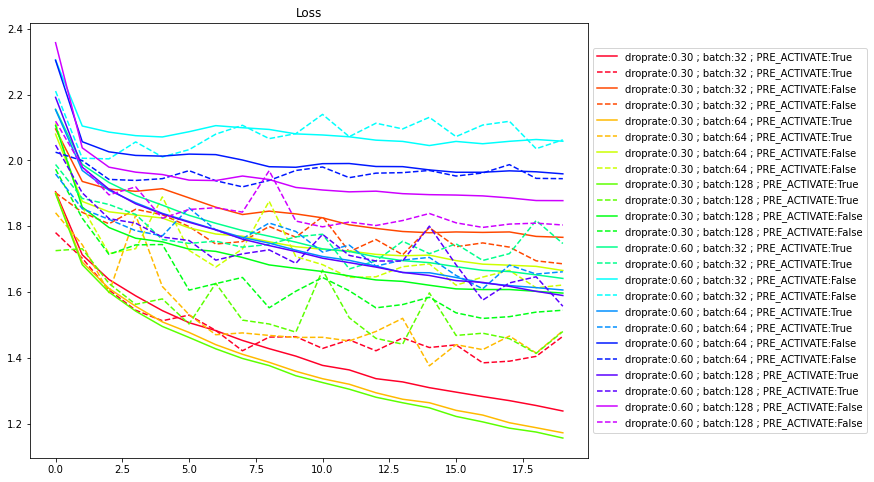

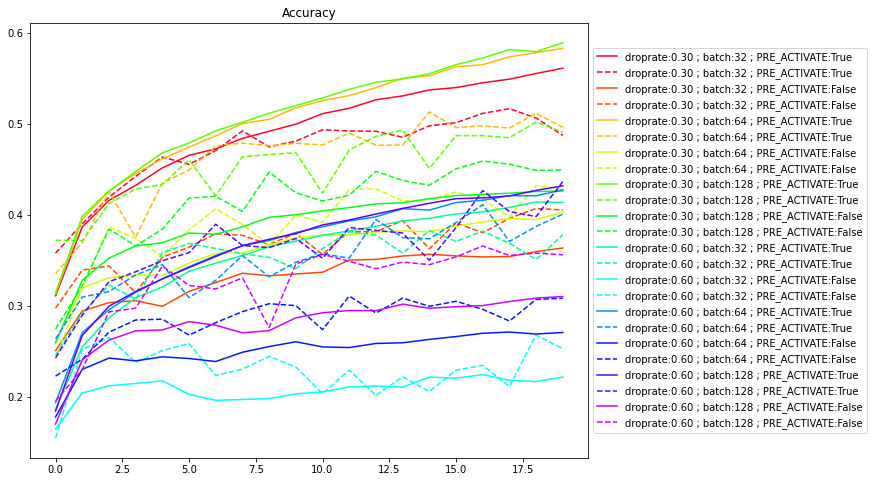

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(10,8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(10,8))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()